<a href="https://colab.research.google.com/github/GustavoEmanuel901/Aulas-ML/blob/main/Clusterizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
df_authors = pd.read_csv("DNP_ancient_authors.csv", index_col="authors").drop(columns=["Unnamed: 0"])

In [ ]:
df_authors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238 entries, Achilles Tatius of Alexandria to Zosimus
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   word_count           238 non-null    int64
 1   modern_translations  238 non-null    int64
 2   known_works          238 non-null    int64
 3   manuscripts          238 non-null    int64
 4   early_editions       238 non-null    int64
 5   early_translations   238 non-null    int64
 6   modern_editions      238 non-null    int64
 7   commentaries         238 non-null    int64
dtypes: int64(8)
memory usage: 24.8+ KB


In [ ]:
df_authors.head()

,word_count,modern_translations,known_works,manuscripts,early_editions,early_translations,modern_editions,commentaries
authors,,,,,,,,
Achilles Tatius of Alexandria,383,5,1,2,3,9,2,1
Aelianus Tacticus,350,1,1,0,3,6,1,0
"Aelianus, Claudius (Aelian)",746,8,3,6,10,8,7,0
Aelius Aristides (Publius Aelius Aristides),2180,26,22,7,11,6,15,1
Aeneas Tacticus,304,5,1,1,1,2,6,0


In [ ]:
df_authors.describe()

,word_count,modern_translations,known_works,manuscripts,early_editions,early_translations,modern_editions,commentaries
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,904.441176,12.970588,4.735294,4.512605,5.823529,4.794118,10.399160,3.815126
std,804.388666,16.553047,6.784297,4.637702,4.250881,6.681706,11.652326,7.013509
min,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,448.750000,4.250000,1.000000,1.000000,3.000000,0.000000,4.000000,0.000000
50%,704.000000,9.000000,2.000000,3.000000,5.000000,2.500000,7.000000,1.000000
75%,1151.500000,15.750000,6.000000,6.000000,8.000000,8.000000,14.000000,4.000000
max,9406.000000,178.000000,65.000000,34.000000,28.000000,39.000000,115.000000,43.000000


In [ ]:
ninety_quantile = df_authors["word_count"].quantile(0.9)
df_authors = df_authors[df_authors["word_count"] <= ninety_quantile]


In [ ]:
from sklearn.preprocessing import StandardScaler as SS # z-score standardization
from sklearn.cluster import KMeans, DBSCAN # clustering algorithms
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.metrics import silhouette_score # used as a metric to evaluate the cohesion in a cluster
from sklearn.neighbors import NearestNeighbors # for selecting the optimal eps value when using DBSCAN
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer


In [ ]:
def silhouettePlot(range_, data):
    '''
    we will use this function to plot a silhouette plot that helps us to evaluate the cohesion in clusters (k-means only)
    '''
    half_length = int(len(range_)/2)
    range_list = list(range_)
    fig, ax = plt.subplots(half_length, 2, figsize=(15,8))
    for _ in range_:
        kmeans = KMeans(n_clusters=_, random_state=42)
        q, mod = divmod(_ - range_list[0], 2)
        sv = SilhouetteVisualizer(kmeans, colors="yellowbrick", ax=ax[q][mod])
        ax[q][mod].set_title("Silhouette Plot with n={} Cluster".format(_))
        sv.fit(data)
    fig.tight_layout()
    fig.show()
    fig.savefig("silhouette_plot.png")


In [ ]:
def elbowPlot(range_, data, figsize=(10,10)):
    '''
    the elbow plot function helps to figure out the right amount of clusters for a dataset
    '''
    inertia_list = []
    for n in range_:
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        inertia_list.append(kmeans.inertia_)

    # plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=inertia_list, x=range_, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range_))
    fig.show()
    fig.savefig("elbow_plot.png")



In [ ]:
def findOptimalEps(n_neighbors, data):
    '''
    function to find optimal eps distance when using DBSCAN; based on this article: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
    '''
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)


In [ ]:
def progressiveFeatureSelection(df, n_clusters=3, max_features=4,):
    '''
    very basic implementation of an algorithm for feature selection (unsupervised clustering); inspired by this post: https://datascience.stackexchange.com/questions/67040/how-to-do-feature-selection-for-clustering-and-implement-it-in-python
    '''
    feature_list = list(df.columns)
    selected_features = list()
    # select starting feature
    initial_feature = ""
    high_score = 0
    for feature in feature_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        data_ = df[feature]
        labels = kmeans.fit_predict(data_.to_frame())
        score_ = silhouette_score(data_.to_frame(), labels)
        print("Proposed new feature {} with score {}". format(feature, score_))
        if score_ >= high_score:
            initial_feature = feature
            high_score = score_
    print("The initial feature is {} with a silhouette score of {}.".format(initial_feature, high_score))
    feature_list.remove(initial_feature)
    selected_features.append(initial_feature)
    for _ in range(max_features-1):
        high_score = 0
        selected_feature = ""
        print("Starting selection {}...".format(_))
        for feature in feature_list:
            selection_ = selected_features.copy()
            selection_.append(feature)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            data_ = df[selection_]
            labels = kmeans.fit_predict(data_)
            score_ = silhouette_score(data_, labels)
            print("Proposed new feature {} with score {}". format(feature, score_))
            if score_ > high_score:
                selected_feature = feature
                high_score = score_
        selected_features.append(selected_feature)
        feature_list.remove(selected_feature)
        print("Selected new feature {} with score {}". format(selected_feature, high_score))
    return selected_features


In [ ]:
scaler = SS()
DNP_authors_standardized = scaler.fit_transform(df_authors)
df_authors_standardized = pd.DataFrame(DNP_authors_standardized, columns=["word_count_standardized", "modern_translations_standardized", "known_works_standardized", "manuscripts_standardized", "early_editions_standardized", "early_translations_standardized", "modern_editions_standardized", "commentaries_standardized"])
df_authors_standardized = df_authors_standardized.set_index(df_authors.index)


In [ ]:
selected_features = progressiveFeatureSelection(df_authors_standardized, max_features=3, n_clusters=3)

Proposed new feature word_count_standardized with score 0.5815823896749474
Proposed new feature modern_translations_standardized with score 0.5917853484820189
Proposed new feature known_works_standardized with score 0.7606223362466435
Proposed new feature manuscripts_standardized with score 0.6126173050657406
Proposed new feature early_editions_standardized with score 0.5572659274387843
Proposed new feature early_translations_standardized with score 0.7025924996773049
Proposed new feature modern_editions_standardized with score 0.6105799708876277
Proposed new feature commentaries_standardized with score 0.7640761496282473
The initial feature is commentaries_standardized with a silhouette score of 0.7640761496282473.
Starting selection 0...
Proposed new feature word_count_standardized with score 0.49823573315720454
Proposed new feature modern_translations_standardized with score 0.4794041704969361
Proposed new feature known_works_standardized with score 0.6073438290962909
Proposed new f

In [ ]:
df_standardized_sliced = df_authors_standardized[selected_features]


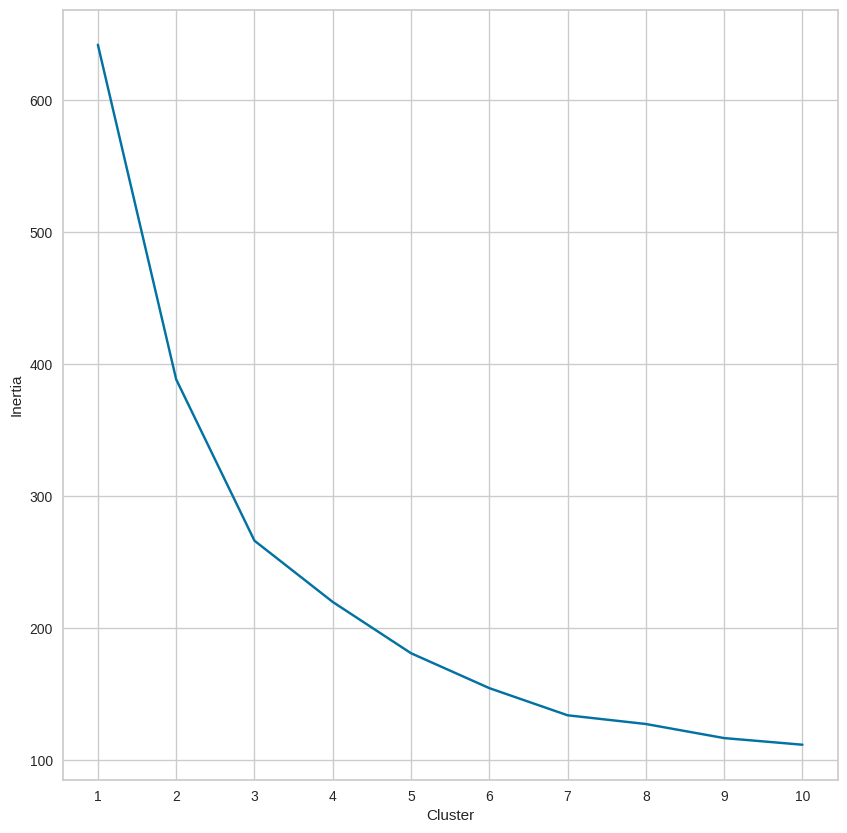

In [ ]:
elbowPlot(range(1,11), df_standardized_sliced)


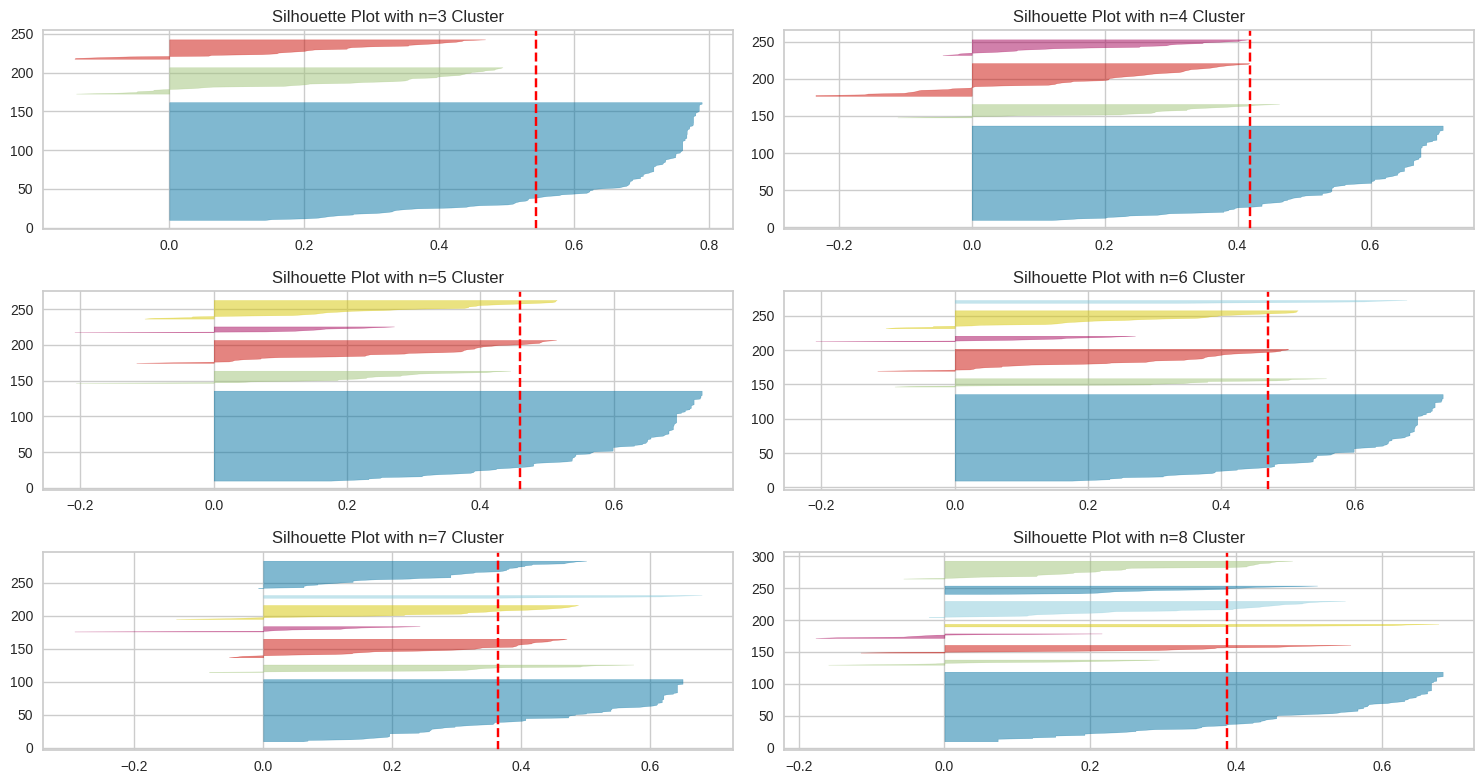

In [ ]:
silhouettePlot(range(3,9), df_standardized_sliced)


<ipython-input-25-164dca96a5bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standardized_sliced["clusters"] = cluster_labels


<Axes: xlabel='pc_1', ylabel='pc_2'>

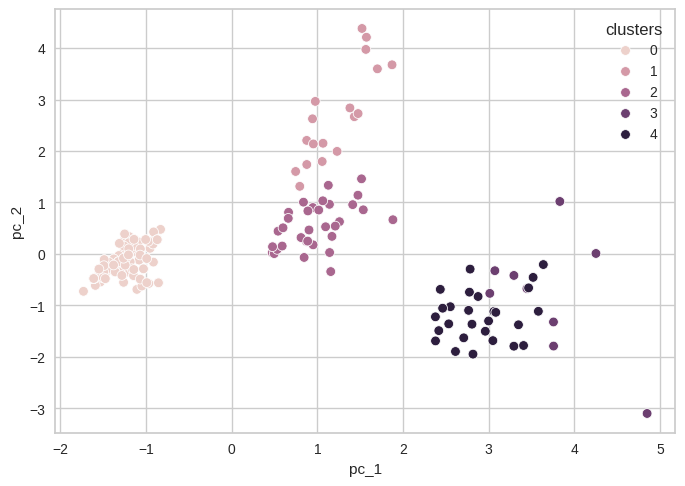

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(df_standardized_sliced)
df_standardized_sliced["clusters"] = cluster_labels

# using PCA to reduce the dimensionality
pca = PCA(n_components=2, whiten=False, random_state=42)
authors_standardized_pca = pca.fit_transform(df_standardized_sliced)
df_authors_standardized_pca = pd.DataFrame(data=authors_standardized_pca, columns=["pc_1", "pc_2"])
df_authors_standardized_pca["clusters"] = cluster_labels

# plotting the clusters with seaborn
sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=df_authors_standardized_pca)


In [ ]:
df_abstracts = pd.read_csv("RELIGION_abstracts.csv").drop(columns="Unnamed: 0")
df_abstracts.info()
df_abstracts.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     701 non-null    object
 1   abstract  701 non-null    object
 2   link      701 non-null    object
 3   volume    701 non-null    object
dtypes: object(4)
memory usage: 22.0+ KB


,title,abstract,link,volume
count,701,701,701,701
unique,701,701,701,40
top,Norwegian Muslims denouncing terrorism: beyond...,"In contemporary European societies, Muslims ar...",https://www.tandfonline.com/doi/full/10.1080/0...,https://www.tandfonline.com/loi/rrel20?treeId=...
freq,1,1,1,41


In [ ]:
import spacy
import re
nlp = spacy.load("en_core_web_sm")

def lemmatizeAbstracts(x):
        doc = nlp(x)
        new_text = []
        for token in doc:
            new_text.append(token.lemma_)
        text_string = " ".join(new_text)
        # getting rid of non-word characters
        text_string = re.sub(r"[^\w\s]+", "", text_string)
        text_string = re.sub(r"\s{2,}", " ", text_string)
        return text_string

df_abstracts["abstract_lemma"] = df_abstracts["abstract"].apply(lemmatizeAbstracts)
df_abstracts.to_csv("RELIGION_abstracts_lemmatized.csv")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english")
df_abstracts_tfidf = tfidf.fit_transform(df_abstracts["abstract_lemma"])


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=250, strip_accents="unicode", min_df=10, max_df=200)
tfidf_religion_array = tfidf.fit_transform(df_abstracts["abstract_lemma"])
# Use get_feature_names_out() instead of get_feature_names()
df_abstracts_tfidf = pd.DataFrame(tfidf_religion_array.toarray(), index=df_abstracts.index, columns=tfidf.get_feature_names_out())
df_abstracts_tfidf.describe()

,academic,account,activity,address,african,agency,aim,allow,american,analyse,...,use,value,various,view,way,western,woman,work,world,year
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,...,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,0.017395,0.017696,0.010628,0.011038,0.011331,0.009074,0.010499,0.009149,0.015161,0.012112,...,0.033088,0.014265,0.013611,0.021308,0.027670,0.021195,0.018491,0.028035,0.028887,0.014515
std,0.063817,0.067372,0.051658,0.047012,0.065546,0.054176,0.045395,0.042515,0.067962,0.051397,...,0.074381,0.061424,0.052614,0.064546,0.062501,0.077924,0.095834,0.074827,0.073781,0.053082
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.494113,0.709618,0.501507,0.360322,0.737092,0.672583,0.386343,0.409185,0.624531,0.453473,...,0.609089,0.828967,0.530361,0.514821,0.364839,0.724380,0.941353,0.604321,0.492094,0.367367


In [ ]:
# using PCA to reduce the dimensionality
pca = PCA(n_components=10, whiten=False, random_state=42)
abstracts_pca = pca.fit_transform(df_abstracts_tfidf)
df_abstracts_pca = pd.DataFrame(data=abstracts_pca)


In [ ]:
kmeans = KMeans(n_clusters=100, random_state=42)
abstracts_labels = kmeans.fit_predict(df_abstracts_pca)
df_abstracts_labeled = df_abstracts.copy()
df_abstracts_labeled["cluster"] = abstracts_labels


In [ ]:
df_abstracts_labeled[df_abstracts_labeled["cluster"] == 75][["title", "cluster"]]

,title,cluster
328,Responding to disasters within the Christian t...,75
341,"Myths, models, and metaphors: Religion as mode...",75
519,St. George the Indigenous Foreigner in Kerala ...,75
523,Fivefold Virtue: Reformulating Mencian Moral P...,75
622,Primitive religious thought and the evolution ...,75


In [ ]:
df_abstracts_labeled[df_abstracts_labeled["cluster"] == 15][["title", "cluster"]]

,title,cluster
95,(Re)producing Buddhist hegemony in Sri Lanka: ...,15
275,On the market: consumption and material cultur...,15
362,Mizuko kuyō in the abortion cultural wars: The...,15
408,Astonishment: A study of an ethically valorise...,15
589,Inclusivism and the spiritual journey of Marie...,15
624,Contemporary Theravāda and Zen Buddhist attitu...,15
632,Buddhaputra and bhumiputra?,15


In [ ]:
df_abstracts_labeled[df_abstracts_labeled["cluster"] == 84][["title", "cluster"]]

,title,cluster
110,The sacred and sacrality: from Eliade to evolu...,84
370,Mircea Eliade: ‘Secular mysticism’ and the his...,84


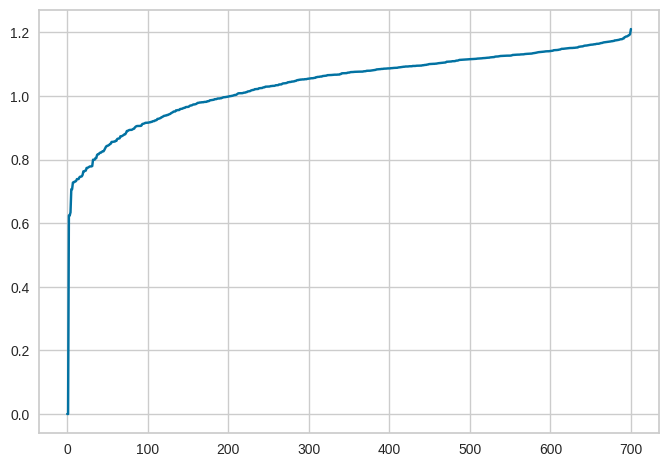

In [ ]:
findOptimalEps(2, df_abstracts_tfidf)

In [ ]:
dbscan = DBSCAN(eps=0.2, metric="euclidean")
dbscan_labels = dbscan.fit_predict(df_abstracts_pca)
df_abstracts_dbscan = df_abstracts.copy()
df_abstracts_dbscan["cluster"] = dbscan_labels
df_abstracts_dbscan["cluster"].unique()


array([ 0, -1,  1,  3,  2,  4,  5])

In [ ]:
df_abstracts_dbscan[df_abstracts_dbscan["cluster"] == 1][["title", "cluster"]]

,title,cluster
14,Imagining Buddhist modernism: the shared relig...,1
20,Why Durkheim really thought that Buddhism was ...,1
158,Textbook Buddhism: introductory books on the B...,1
275,On the market: consumption and material cultur...,1
406,A new Buddhist sect?: The Dhammakāya temple an...,1
439,Recent trends in Sri Lankan Buddhism,1
471,William James and Buddhism: American Pragmatis...,1
559,Buddhist Environmental Ethics and Detraditiona...,1
589,Inclusivism and the spiritual journey of Marie...,1
620,Buddhadharma and contemporary ethics,1


In [ ]:
df_abstracts_dbscan[df_abstracts_dbscan["cluster"] == 2][["title", "cluster"]]

,title,cluster
209,Three cognitive routes to atheism: a dual-proc...,2
282,THE CULTURAL TRANSMISSION OF FAITH Why innate ...,2
321,"Religion is natural, atheism is not: On why ev...",2
322,Atheism is only skin deep: Geertz and Markusso...,2
323,The relative unnaturalness of atheism: On why ...,2
378,The science of religious beliefs,2
